Connected to Python 3.13.3


Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

       green       0.99      0.96      0.98      1423
      orange       0.98      0.99      0.99      1572
         red       0.98      1.00      0.99      1442
      yellow       0.96      0.97      0.97      1472

    accuracy                           0.98      5909
   macro avg       0.98      0.98      0.98      5909
weighted avg       0.98      0.98      0.98      5909



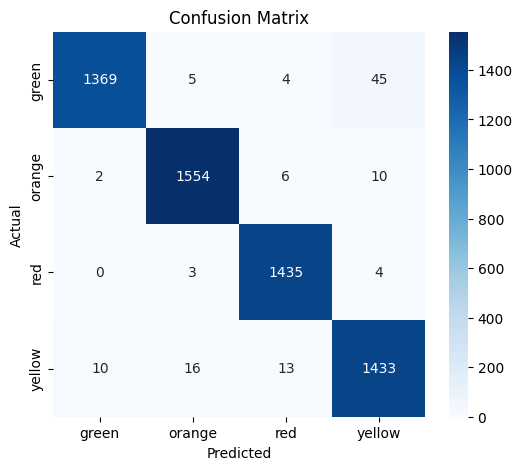

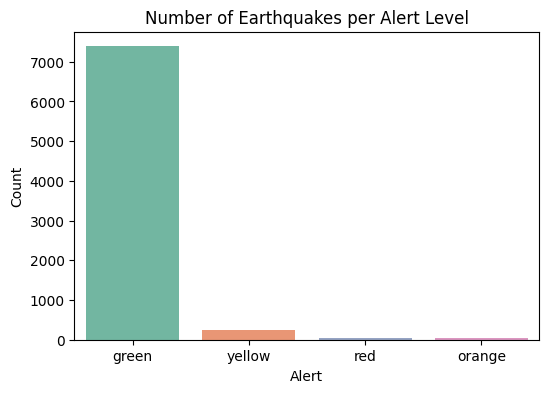

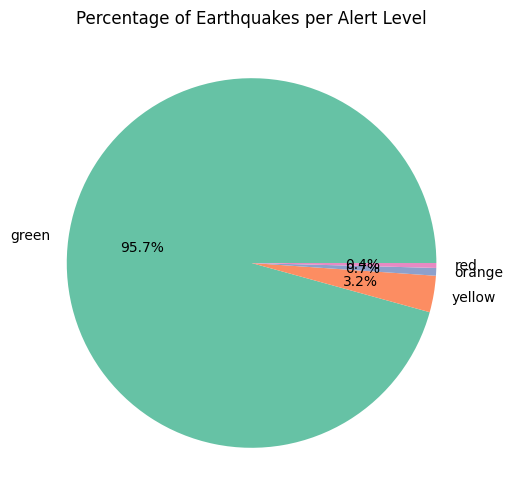

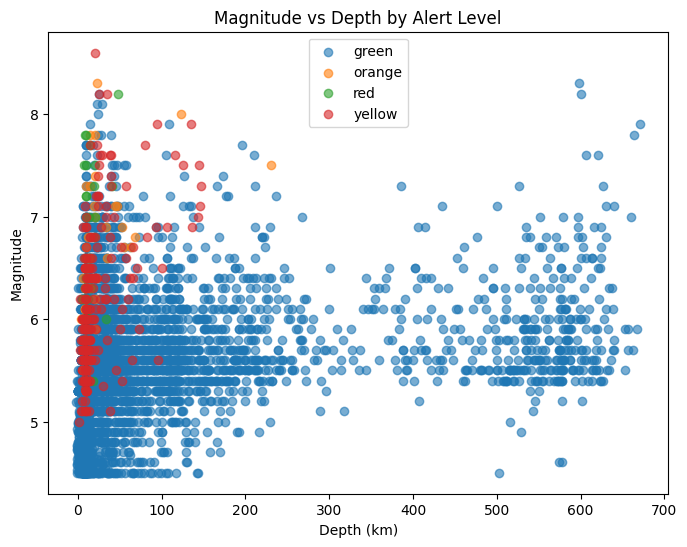

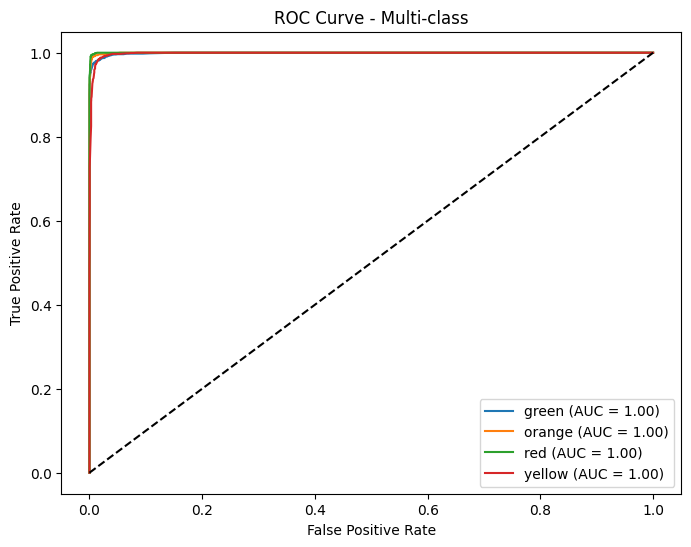

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import joblib

# Step 2: Load dataset
df = pd.read_csv('earthquakes.csv')
df = df.dropna(subset=['latitude','longitude','depth','mag','Alert'])

# Features and target
features = ['latitude', 'longitude', 'depth', 'mag']
X = df[features]
y = df['Alert']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance classes with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Save model
joblib.dump(clf, "earthquake_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

# Step 3: Model Evaluation
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 4: Visualizations

# 4a. Bar chart: Count per alert level
plt.figure(figsize=(6,4))
sns.countplot(x='Alert', data=df, hue='Alert', dodge=False, palette='Set2', legend=False)
plt.title('Number of Earthquakes per Alert Level')
plt.ylabel('Count')
plt.show()

# 4b. Pie chart: Percentage per alert level
plt.figure(figsize=(6,6))
df['Alert'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Percentage of Earthquakes per Alert Level')
plt.ylabel('')
plt.show()

# 4c. Line chart: Magnitude vs Depth
plt.figure(figsize=(8,6))
for alert in le.classes_:
    subset = df[df['Alert']==alert]
    plt.scatter(subset['depth'], subset['mag'], label=alert, alpha=0.6)
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.title('Magnitude vs Depth by Alert Level')
plt.legend()
plt.show()

# 4d. ROC Curve (Multi-class)
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_pred_prob = clf.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend()
plt.show()

